In [1]:
import pandas as pd
import numpy as np
import holidays
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_cleaned=pd.read_csv("/content/drive/MyDrive/Research_s3/Dataset/data_cleaned (1).csv")

<ipython-input-3-d2bfad8ec787>:1: DtypeWarning: Columns (14,16,17,18,19,20,21,23,25,27,50,51,52,53,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned=pd.read_csv("/content/drive/MyDrive/Research_s3/Dataset/data_cleaned (1).csv")


In [ ]:
df_cleaned.shape

(1106557, 56)

# Acute nasopharyngits


In [4]:
# Dictionary of models
models_dict = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "xgboost" : XGBRegressor(objective='reg:squarederror', random_state=42),
    "LightGBM": LGBMRegressor(random_state=42)
}

# Ensure the date column is in datetime format and lowercase 'diagnosis'
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
df_cleaned['diagnosis'] = df_cleaned['diagnosis'].str.lower()

# Filter for acute respiratory tract infection cases
filtered_data = df_cleaned[df_cleaned['diagnosis'].str.contains('cough', na=False)]

def preprocess_data(df):
    time_series = df.groupby('date').agg({'age': 'mean', 'diagnosis': 'count'}).reset_index()
    time_series.rename(columns={'diagnosis': 'diagnosis_count'}, inplace=True)

    # Temporal features
    time_series['month'] = time_series['date'].dt.month
    time_series['day_of_week'] = time_series['date'].dt.dayofweek
    time_series['year'] = time_series['date'].dt.year
    time_series['is_weekend'] = time_series['day_of_week'].isin([5, 6]).astype(int)

    india_holidays = holidays.India(years=range(time_series['year'].min(), time_series['year'].max() + 1))
    time_series['is_holiday'] = time_series['date'].isin(india_holidays).astype(int)

    # Lag and rolling features
    for lag in range(1, 8):
        time_series[f'diagnosis_count_lag_{lag}'] = time_series['diagnosis_count'].shift(lag)

    time_series['rolling_mean_3'] = time_series['diagnosis_count'].rolling(window=3).mean()
    time_series['rolling_mean_7'] = time_series['diagnosis_count'].rolling(window=7).mean()

    return time_series.dropna()

In [5]:
# Preprocess data
time_series = preprocess_data(filtered_data)

# Train-test split
max_date = time_series['date'].max()
train_data = time_series[time_series['date'] <= max_date - pd.DateOffset(months=7)]
test_data = time_series[time_series['date'] > max_date - pd.DateOffset(months=7)]

features = ['age', 'month', 'day_of_week', 'year', 'is_weekend', 'is_holiday'] + \
           [f'diagnosis_count_lag_{i}' for i in range(1, 8)] + \
           ['rolling_mean_3', 'rolling_mean_7']
X_train, y_train = train_data[features], train_data['diagnosis_count']
X_test, y_test = test_data[features], test_data['diagnosis_count']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store results
results = {}

# Train and evaluate models
for name, model in models_dict.items():
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    results[name] = {
        "Train R2": r2_score(y_train, y_train_pred),
        "Test R2": r2_score(y_test, y_test_pred)
    }


<ipython-input-4-b2155118d45a>:26: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  time_series['is_holiday'] = time_series['date'].isin(india_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 551, number of used features: 14
[LightGBM] [Info] Start training from score 105.125227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [6]:

# LSTM Model
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=0)

y_train_pred_lstm = lstm_model.predict(X_train_lstm)
y_test_pred_lstm = lstm_model.predict(X_test_lstm)

results["LSTM"] = {
    "Train R2": r2_score(y_train, y_train_pred_lstm.flatten()),
    "Test R2": r2_score(y_test, y_test_pred_lstm.flatten())
}

print(results)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
{'Random Forest': {'Train R2': 0.9817213312267473, 'Test R2': 0.8928299728330007}, 'xgboost': {'Train R2': 0.9999991655349731, 'Test R2': 0.9154627323150635}, 'LightGBM': {'Train R2': 0.9898008266190944, 'Test R2': 0.9174474765227871}, 'LSTM': {'Train R2': 0.5725765228271484, 'Test R2': 0.6605832576751709}}


**XGBoost has been performing well, so  fine-tune its hyperparameters for optimal performance.**



In [7]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

gxboost = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=gxboost, param_grid=param_grid, scoring='r2', cv=3, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

# Print best parameters before proceeding
best_params = grid_search.best_params_
print("Best Parameters for XGBoost:", best_params)


Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}


<ipython-input-8-efc4c7ea64e2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['predicted'] = y_train_pred
<ipython-input-8-efc4c7ea64e2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted'] = y_test_pred


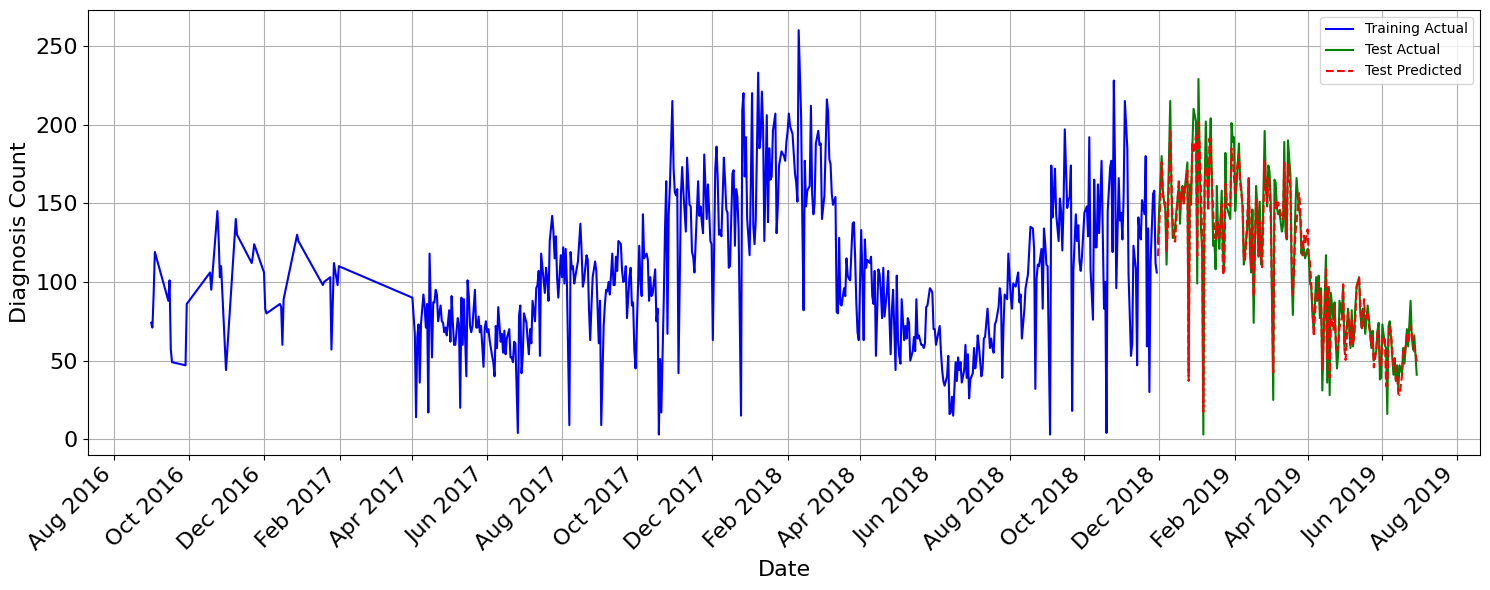

In [8]:

# Best model from GridSearchCV
best_xgb = grid_search.best_estimator_
y_train_pred = best_xgb.predict(X_train_scaled)
y_test_pred = best_xgb.predict(X_test_scaled)

# Store best XGBoost results
results["XGBoost_HyperTuned"] = {
    "Train R2": r2_score(y_train, y_train_pred),
    "Test R2": r2_score(y_test, y_test_pred)
}

# Combine actual and predicted data for visualization
train_data['predicted'] = y_train_pred
test_data['predicted'] = y_test_pred
full_data = pd.concat([train_data, test_data])
full_data = full_data[['date', 'diagnosis_count', 'predicted']]
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot results
fig, ax = plt.subplots(figsize=(15, 6))

ax.set_xlabel("Date", fontsize=16)  # X-axis label font size
ax.set_ylabel("Diagnosis Count", fontsize=16)  # Y-axis label font size

ax.plot(train_data['date'], train_data['diagnosis_count'], label="Training Actual", color="blue", linewidth=1.5)
ax.plot(test_data['date'], test_data['diagnosis_count'], label="Test Actual", color="green", linestyle="-", linewidth=1.5)
ax.plot(test_data['date'], test_data['predicted'], label="Test Predicted", color="red", linestyle="--", linewidth=1.5)

# Increase x-axis (Date) label frequency and formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Increase font size of tick values on both axes
ax.tick_params(axis='x', labelsize=16)  # X-axis values (dates)
ax.tick_params(axis='y', labelsize=16)  # Y-axis values (diagnosis count)

plt.xticks(rotation=45, ha="right")  # Rotate x-axis values for better visibility
ax.legend()
ax.grid()
plt.tight_layout()
plt.savefig("forecast_plot_xgboost_tuned.png", dpi=300)
plt.show()




### Printing the accuracy

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Compute evaluation metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Store best XGBoost results with R2 and RMSE
results["XGBoost_HyperTuned"] = {
    "Train R2": train_r2,
    "Test R2": test_r2,
    "Train RMSE": train_rmse,
    "Test RMSE": test_rmse
}

# Print results
print(f"Best Parameters for XGBoost: {best_params}")
print(f"Train R² Score: {train_r2:.4f}, Train RMSE: {train_rmse:.4f}")
print(f"Test R² Score: {test_r2:.4f}, Test RMSE: {test_rmse:.4f}")


Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
Train R² Score: 0.9974, Train RMSE: 2.3713
Test R² Score: 0.9548, Test RMSE: 10.3975
